In [1]:
import scvelo as scv
import anndata as ad
import scanpy as sc
import pandas as pd
import mygene
from scipy.sparse import csr_matrix, save_npz, load_npz

In [9]:
# Load the sparse matrix
count_matrix = load_npz("/home/users/kzlin/kzlinlab/projects/veloUncertainty/out/kevin/Writeup13/rna_sparse_counts.npz")
spliced_matrix = load_npz("/home/users/kzlin/kzlinlab/projects/veloUncertainty/out/kevin/Writeup13/rna_sparse_spliced_counts.npz")
unspliced_matrix = load_npz("/home/users/kzlin/kzlinlab/projects/veloUncertainty/out/kevin/Writeup13/rna_sparse_unspliced_counts.npz")

In [14]:
#    Assuming `rna_cell_metadata.txt` has rows of cells and columns for metadata,
#    and that one of these columns (likely the index) matches the cell names in `counts.columns`.
cell_metadata = pd.read_csv("/home/users/kzlin/kzlinlab/data/greanleaf_brain_multiome/rna_cell_metadata.txt", sep='\t', index_col=0)

In [8]:
# Load row and column names
gene_names = pd.read_csv("/home/users/kzlin/kzlinlab/projects/veloUncertainty/out/kevin/Writeup13/rna_gene_names.txt", 
                         header=None)
cell_names = pd.read_csv("/home/users/kzlin/kzlinlab/projects/veloUncertainty/out/kevin/Writeup13/rna_cell_names.txt", 
                         header=None)


spliced_gene_names = pd.read_csv("/home/users/kzlin/kzlinlab/projects/veloUncertainty/out/kevin/Writeup13/rna_spliced_gene_names.txt", 
                         header=None)
spliced_cell_names = pd.read_csv("/home/users/kzlin/kzlinlab/projects/veloUncertainty/out/kevin/Writeup13/rna_spliced_cell_names.txt", 
                         header=None)

unspliced_gene_names = pd.read_csv("/home/users/kzlin/kzlinlab/projects/veloUncertainty/out/kevin/Writeup13/rna_unspliced_gene_names.txt", 
                         header=None)
unspliced_cell_names = pd.read_csv("/home/users/kzlin/kzlinlab/projects/veloUncertainty/out/kevin/Writeup13/rna_unspliced_cell_names.txt", 
                         header=None)


In [10]:
# Extract gene and cell lists (as Series for convenience)
count_genes = gene_names[0]      # gene_names read from the count matrix file
count_cells = cell_names[0]

spliced_genes = spliced_gene_names[0]
spliced_cells = spliced_cell_names[0]

unspliced_genes = unspliced_gene_names[0]
unspliced_cells = unspliced_cell_names[0]

# Find common genes and cells across all three sets
common_genes = set(count_genes).intersection(spliced_genes, unspliced_genes)
common_cells = set(count_cells).intersection(spliced_cells, unspliced_cells)

# Convert back to lists (or Series) and preserve the original order of the count matrix
common_genes = count_genes[count_genes.isin(common_genes)]
common_cells = count_cells[count_cells.isin(common_cells)]

# We now have ordered lists of genes and cells that are common to all three matrices.

In [11]:
print(common_cells)
print(common_genes)

0        hft_w20_p3_r1_AAACCCAAGCTGCGAA
1        hft_w20_p3_r1_AAACCCAAGGTAGTAT
2        hft_w20_p3_r1_AAACCCACAACTCCAA
3        hft_w20_p3_r1_AAACCCACATAGTCAC
4        hft_w20_p3_r1_AAACCCAGTACAGGTG
                      ...              
57863    hft_w16_p7_r2_TTTGTTGCAGCACCCA
57864    hft_w16_p7_r2_TTTGTTGCAGGCTACC
57865    hft_w16_p7_r2_TTTGTTGGTCGCTTAA
57866    hft_w16_p7_r2_TTTGTTGGTCGTACAT
57867    hft_w16_p7_r2_TTTGTTGGTTAGTTCG
Name: 0, Length: 57868, dtype: object
0        ENSG00000243485
1        ENSG00000237613
2        ENSG00000186092
3        ENSG00000238009
4        ENSG00000239945
              ...       
33350    ENSG00000212907
33351    ENSG00000198886
33352    ENSG00000198786
33353    ENSG00000198695
33354    ENSG00000198727
Name: 0, Length: 32648, dtype: object


In [12]:
# Next, we need to determine the indices of these common genes and cells in each matrix.
# For each matrix, we know the original rows correspond to genes and columns to cells.

# Create a mapping from gene_name to original row index for each matrix:
count_gene_to_idx = pd.Series(range(count_genes.shape[0]), index=count_genes)
spliced_gene_to_idx = pd.Series(range(spliced_genes.shape[0]), index=spliced_genes)
unspliced_gene_to_idx = pd.Series(range(unspliced_genes.shape[0]), index=unspliced_genes)

# Similarly for cells:
count_cell_to_idx = pd.Series(range(count_cells.shape[0]), index=count_cells)
spliced_cell_to_idx = pd.Series(range(spliced_cells.shape[0]), index=spliced_cells)
unspliced_cell_to_idx = pd.Series(range(unspliced_cells.shape[0]), index=unspliced_cells)

# Get the integer indices for the common genes and cells for each matrix
count_gene_idx = count_gene_to_idx[common_genes].values
count_cell_idx = count_cell_to_idx[common_cells].values

spliced_gene_idx = spliced_gene_to_idx[common_genes].values
spliced_cell_idx = spliced_cell_to_idx[common_cells].values

unspliced_gene_idx = unspliced_gene_to_idx[common_genes].values
unspliced_cell_idx = unspliced_cell_to_idx[common_cells].values

In [13]:
# Now subset each matrix by common genes and cells
# Remember the shape of the matrices should be (n_genes, n_cells) 
# If they are not in that shape (e.g., cells in rows, genes in columns),
# adjust indexing accordingly.

count_matrix_sub = count_matrix[ count_gene_idx[:, None], count_cell_idx ]
spliced_matrix_sub = spliced_matrix[ spliced_gene_idx[:, None], spliced_cell_idx ]
unspliced_matrix_sub = unspliced_matrix[ unspliced_gene_idx[:, None], unspliced_cell_idx ]

# Now all three matrices correspond to the same sets of genes and cells in the same order.
# common_genes and common_cells hold the ordered names.

In [23]:
cell_metadata_sub = cell_metadata.loc[common_cells]

In [24]:
count_matrix_sub.shape

(32648, 57868)

In [25]:
adata = ad.AnnData(
    X=count_matrix_sub.T,
    obs=cell_metadata_sub,
    var=pd.DataFrame(index=common_genes)
)

In [27]:
# 6. Add layers for spliced and unspliced counts
adata.layers["spliced"] = spliced_matrix_sub.T
adata.layers["unspliced"] = unspliced_matrix_sub.T

In [28]:
adata

AnnData object with n_obs × n_vars = 57868 × 32648
    obs: 'Sample.ID', 'Age', 'Tissue.ID', 'Sample.Type', 'Assay', 'Batch', 'seurat_clusters', 'RNA.Counts', 'RNA.Features', 'Percent.MT', 'Percent.Ribo', 'Cell.Barcode', 'DF_pANN', 'DF_classification', 'DF_pANN_quantile', 'Spliced.Counts', 'Spliced.Features', 'Unspliced.Counts', 'Unspliced.Features', 'Ambiguous.Counts', 'Ambiguous.Features'
    layers: 'spliced', 'unspliced'

In [29]:
print(adata.obs_names)
print(adata.var_names)

Index(['hft_w20_p3_r1_AAACCCAAGCTGCGAA', 'hft_w20_p3_r1_AAACCCAAGGTAGTAT',
       'hft_w20_p3_r1_AAACCCACAACTCCAA', 'hft_w20_p3_r1_AAACCCACATAGTCAC',
       'hft_w20_p3_r1_AAACCCAGTACAGGTG', 'hft_w20_p3_r1_AAACCCAGTACGGTTT',
       'hft_w20_p3_r1_AAACCCAGTACTCGCG', 'hft_w20_p3_r1_AAACCCAGTATGTCCA',
       'hft_w20_p3_r1_AAACCCAGTGTATTCG', 'hft_w20_p3_r1_AAACCCAGTTGCTCAA',
       ...
       'hft_w16_p7_r2_TTTGGTTTCACGACTA', 'hft_w16_p7_r2_TTTGGTTTCCCTTTGG',
       'hft_w16_p7_r2_TTTGGTTTCCTCAGAA', 'hft_w16_p7_r2_TTTGGTTTCGGAATGG',
       'hft_w16_p7_r2_TTTGTTGCAATTCGTG', 'hft_w16_p7_r2_TTTGTTGCAGCACCCA',
       'hft_w16_p7_r2_TTTGTTGCAGGCTACC', 'hft_w16_p7_r2_TTTGTTGGTCGCTTAA',
       'hft_w16_p7_r2_TTTGTTGGTCGTACAT', 'hft_w16_p7_r2_TTTGTTGGTTAGTTCG'],
      dtype='object', name='Cell.ID', length=57868)
Index(['ENSG00000243485', 'ENSG00000237613', 'ENSG00000186092',
       'ENSG00000238009', 'ENSG00000239945', 'ENSG00000239906',
       'ENSG00000241599', 'ENSG00000236601', 'ENSG00000284

In [30]:
# Read the cluster names file
cluster_df = pd.read_csv("/home/users/kzlin/kzlinlab/data/greanleaf_brain_multiome/scRNA_Colors.txt", sep='\t')
cluster_df

,cluster,potential name,potential description,cell class,dominantTime,color,order
0,c0,excitatory neuron 1,Migrating glutamatergic neurons 1,exNeuron,pcw20to24,#02e493,1
1,c1,GABAergic neuron 1 (CGE),Interneurons 1,inNeuron,mixed,#d89aff,2
2,c2,excitatory neuron 2,Migrating glutamatergic neurons 2,exNeuron,pcw16,#25b9ae,3
3,c3,GABAergic neuron 1 (MGE),Interneurons 2,inNeuron,mixed,#ffaaa4,4
4,c4,excitatory neuron 3,Glutamatergic neurons 1,exNeuron,pcw21,#80ff9c,5
5,c5,excitatory neuron 4,Glutamatergic neurons 2,exNeuron,pcw16,#00c4f7,6
6,c6,radial glia 1 (oRG),Outer radial glia 1,RG,pcw16,#ff895f,7
7,c7,excitatory neuron 5,Glutamatergic neurons 3,exNeuron,pcw16,#9ed4ff,8
8,c8,cycling RG/IPC,Cycling progenitors,RG,mixed,#ffae5c,9
9,c9,excitatory neuron 6,Low quality cells,exNeuron,pcw16,#33FBFF,10


In [31]:
# Create a dictionary mapping Cluster.ID (e.g. c0) to Cluster.Name (e.g. nIPC/GluN1)
cluster_map = dict(zip(cluster_df['cluster'], cluster_df['potential name']))

# Now map these to a new column in adata.obs
adata.obs['cluster_name'] = adata.obs['seurat_clusters'].map(cluster_map)

In [32]:
adata.obs['cluster_name'].value_counts()

cluster_name
excitatory neuron 1         11367
GABAergic neuron 1 (CGE)     5510
excitatory neuron 2          4984
GABAergic neuron 1 (MGE)     4337
excitatory neuron 3          3954
excitatory neuron 4          3784
radial glia 1 (oRG)          3155
excitatory neuron 5          2703
cycling RG/IPC               2701
excitatory neuron 6          2685
radial glia 2 (oRG)          1969
radial glia 3                1920
excitatory neuron 7          1627
subplate neuron              1333
intermediate progenitor      1303
excitatory neuron 8          1210
microglia                     944
OPC/oligodendrocytes          873
radial glia 4                 713
mural cell                    448
endothelial cell              273
unknown 1                      45
unknown 2                      30
Name: count, dtype: int64

Preprocess

In [33]:
scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

Filtered out 19012 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.


/home/users/kzlin/miniconda3/envs/scvelo/lib/python3.9/site-packages/scvelo/preprocessing/utils.py:705: DeprecationWarning: `log1p` is deprecated since scVelo v0.3.0 and will be removed in a future version. Please use `log1p` from `scanpy.pp` instead.
  log1p(adata)
/tmp/ipykernel_2384356/3334712381.py:2: DeprecationWarning: Automatic neighbor calculation is deprecated since scvelo==0.4.0 and will be removed in a future version of scVelo. Please compute neighbors first with Scanpy.
  scv.pp.moments(adata, n_pcs=30, n_neighbors=30)
/home/users/kzlin/miniconda3/envs/scvelo/lib/python3.9/site-packages/scvelo/preprocessing/moments.py:71: DeprecationWarning: `neighbors` is deprecated since scvelo==0.4.0 and will be removed in a future version of scVelo. Please compute neighbors with Scanpy.
  neighbors(
/home/users/kzlin/miniconda3/envs/scvelo/lib/python3.9/site-packages/scvelo/preprocessing/neighbors.py:233: DeprecationWarning: Automatic computation of PCA is deprecated since scvelo==0.4.0

computing neighbors
    finished (0:00:56) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:08) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [34]:
sc.tl.pca(adata)

In [35]:
sc.tl.umap(adata)

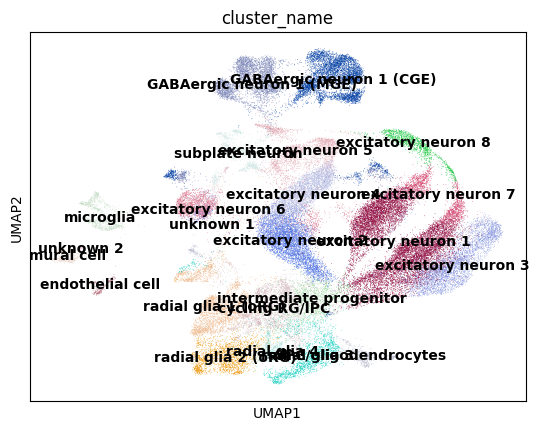

In [36]:
sc.pl.umap(
    adata,
    color="cluster_name",
    # Setting a smaller point size to get prevent overlap
    size=1,
    legend_loc="on data"
)

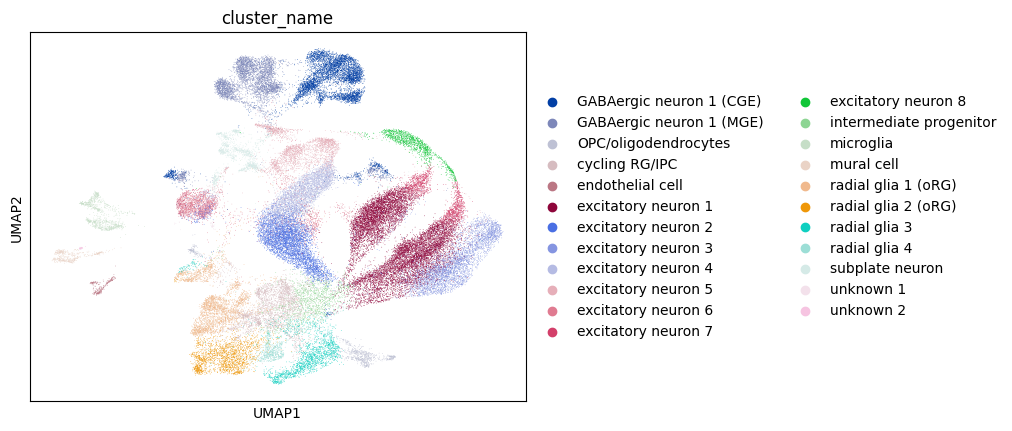

In [37]:
sc.pl.umap(
    adata,
    color="cluster_name",
    # Setting a smaller point size to get prevent overlap
    size=1
)

In [41]:
umap_df = pd.read_csv("/home/users/kzlin/kzlinlab/data/greanleaf_brain_multiome/umapModel_rna_hft_uwot.csv", index_col=0)

In [60]:
umap_df.index = cell_names[0]

In [61]:
print(umap_df)
print(cell_names)

                                       V1         V2
0                                                   
hft_w20_p3_r1_AAACCCAAGCTGCGAA  -9.098179   3.440839
hft_w20_p3_r1_AAACCCAAGGTAGTAT  -5.120800 -13.883694
hft_w20_p3_r1_AAACCCACAACTCCAA   0.721189 -13.250707
hft_w20_p3_r1_AAACCCACATAGTCAC   2.725286   0.889264
hft_w20_p3_r1_AAACCCAGTACAGGTG  -0.154020   2.910998
...                                   ...        ...
hft_w16_p7_r2_TTTGTTGCAGCACCCA  -9.751943  -8.742704
hft_w16_p7_r2_TTTGTTGCAGGCTACC   2.068615  -7.356621
hft_w16_p7_r2_TTTGTTGGTCGCTTAA  -0.904021  -2.956015
hft_w16_p7_r2_TTTGTTGGTCGTACAT  -2.115465  -2.722276
hft_w16_p7_r2_TTTGTTGGTTAGTTCG -10.712273  -8.820245

[57868 rows x 2 columns]
                                    0
0      hft_w20_p3_r1_AAACCCAAGCTGCGAA
1      hft_w20_p3_r1_AAACCCAAGGTAGTAT
2      hft_w20_p3_r1_AAACCCACAACTCCAA
3      hft_w20_p3_r1_AAACCCACATAGTCAC
4      hft_w20_p3_r1_AAACCCAGTACAGGTG
...                               ...
57863  hft_w16_p7_r

In [62]:
common_cells = set(count_cells).intersection(spliced_cells, unspliced_cells)
common_cells = count_cells[count_cells.isin(common_cells)]
print(common_cells)

0        hft_w20_p3_r1_AAACCCAAGCTGCGAA
1        hft_w20_p3_r1_AAACCCAAGGTAGTAT
2        hft_w20_p3_r1_AAACCCACAACTCCAA
3        hft_w20_p3_r1_AAACCCACATAGTCAC
4        hft_w20_p3_r1_AAACCCAGTACAGGTG
                      ...              
57863    hft_w16_p7_r2_TTTGTTGCAGCACCCA
57864    hft_w16_p7_r2_TTTGTTGCAGGCTACC
57865    hft_w16_p7_r2_TTTGTTGGTCGCTTAA
57866    hft_w16_p7_r2_TTTGTTGGTCGTACAT
57867    hft_w16_p7_r2_TTTGTTGGTTAGTTCG
Name: 0, Length: 57868, dtype: object


In [63]:
# Subset umap_df to these cells in the same order as they appear in adata
umap_sub = umap_df.loc[adata.obs_names.intersection(common_cells)]

In [64]:
# Convert to numpy array
adata.obsm["X_umap_greenleaf"] = umap_sub.values

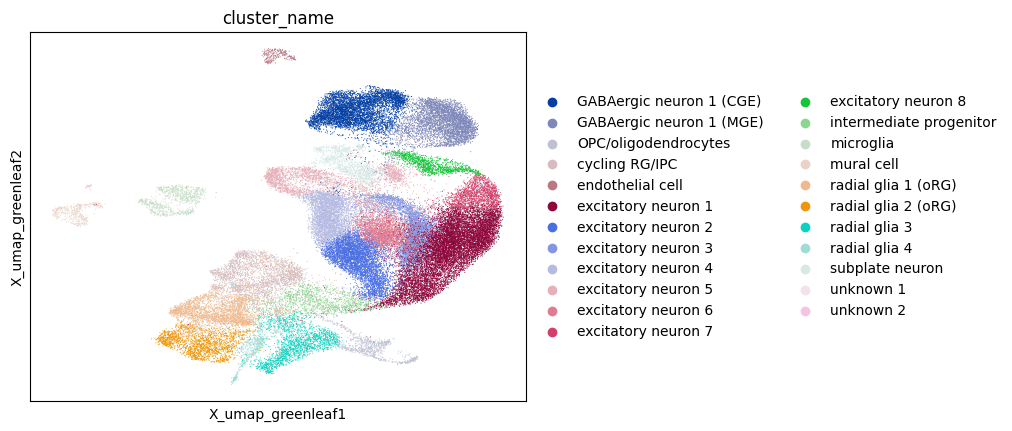

In [65]:
sc.pl.embedding(adata, basis="X_umap_greenleaf", color="cluster_name")

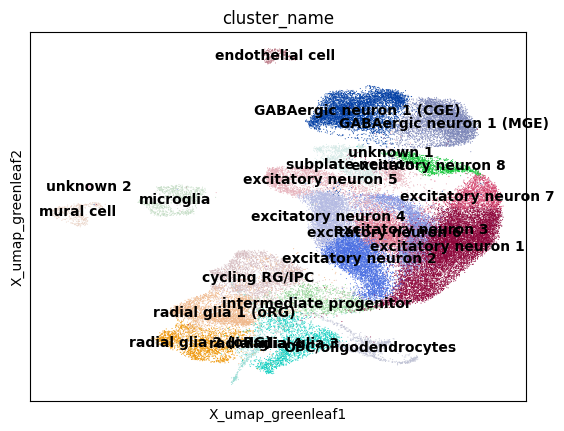

In [66]:
sc.pl.embedding(adata, basis="X_umap_greenleaf", color="cluster_name",legend_loc="on data")

In [67]:
# Define the cell types to keep
cell_types_to_keep = [
    "cycling RG/IPC",
    "radial glia 1 (oRG)",
    "intermediate progenitor",
    "excitatory neuron 1",
    "excitatory neuron 2",
    "excitatory neuron 3",
    "excitatory neuron 6",
    "excitatory neuron 4",
    "excitatory neuron 5",
    "excitatory neuron 7"
]

# Subset the AnnData object
adata = adata[adata.obs["cluster_name"].isin(cell_types_to_keep)].copy()

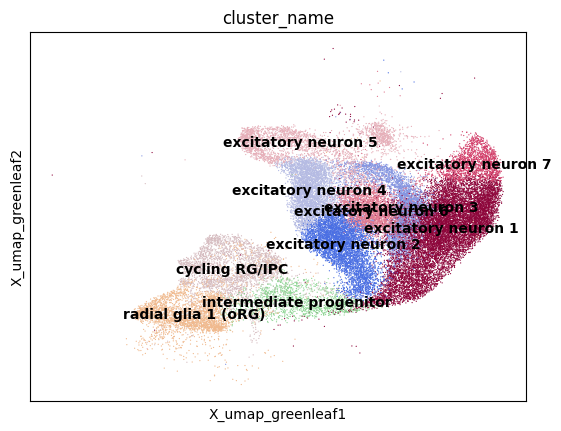

In [68]:
sc.pl.embedding(adata, basis="X_umap_greenleaf", color="cluster_name",legend_loc="on data")

RNA velocity (scVelo)

In [75]:
scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000, enforce=True)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

Filtered out 25 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Skip filtering by dispersion since number of variables are less than `n_top_genes`.
Logarithmized X.
or is corrupted (e.g. due to subsetting). Consider recomputing with `pp.neighbors`.
computing moments based on connectivities


/home/users/kzlin/miniconda3/envs/scvelo/lib/python3.9/site-packages/scvelo/preprocessing/utils.py:705: DeprecationWarning: `log1p` is deprecated since scVelo v0.3.0 and will be removed in a future version. Please use `log1p` from `scanpy.pp` instead.
  log1p(adata)


    finished (0:00:04) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [76]:
scv.tl.velocity(adata)

computing velocities


/home/users/kzlin/miniconda3/envs/scvelo/lib/python3.9/site-packages/scvelo/tools/optimization.py:184: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  gamma[i] = np.linalg.pinv(A.T.dot(A)).dot(A.T.dot(y[:, i]))


    finished (0:00:04) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


In [77]:
scv.tl.velocity_graph(adata)

or is corrupted (e.g. due to subsetting). Consider recomputing with `pp.neighbors`.


ValueError: Your neighbor graph seems to be corrupted. Consider recomputing via pp.neighbors.

In [ ]:
scv.pl.velocity_embedding_stream(adata, basis='umap', color='cluster_name')